In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
from datetime import timedelta

In [3]:
position_path = "./Data/"
data_path = "./Data/RealRun/"
output_path ="./"



'''Create single CR6 dataframe with datetime for comparisons'''
dict={}
for i in tqdm(range(5462,13774)): #create dataframe of all CR6 data
    try:
        outputsize = len(dict)

        df_CR6 = pd.read_table(data_path+"Younng10Hz"+str(i)+".dat",
                           sep=",",
                          skiprows=[0,2,3])

        for j in range(len(df_CR6)):
            if "." in df_CR6['TIMESTAMP'][j]:
                date = datetime.strptime(df_CR6['TIMESTAMP'][j], '%Y-%m-%d %H:%M:%S.%f')
            else:
                date = datetime.strptime(df_CR6['TIMESTAMP'][j], '%Y-%m-%d %H:%M:%S')

            dict[outputsize+j]={"TIMESTAMP":date,"Record":df_CR6['RECORD'][j],"U (m s^-1)":df_CR6['U'][j],"V (m s^-1)":df_CR6['V'][j],"W (m s^-1)":df_CR6['W'][j],"TSonic (K)":df_CR6['TSonic'][j],"RH (%)":df_CR6['RH'][j],"T_HMP60 (C)":df_CR6['T_HMP60'][j]}    

    
    except: #if the file is missing just skip it (this happens twice, nothing needed luckily)
        pass
        
df_CR6 = pd.DataFrame.from_dict(dict, "index") #convert dict to dataframe (this is faster)




100%|██████████████████████████████████████████████████████████████████████████████| 8312/8312 [01:59<00:00, 69.73it/s]


In [5]:
'''START LOOP HERE!!!'''
inputFiles = ['2020-10-02 16-00.xlsx','2020-10-02 16-30.xlsx','2020-10-02 17-00.xlsx','2020-10-02 17-31.xlsx','2020-10-02 18-00.xlsx','2020-10-02 18-30.xlsx','2020-10-02 19-00.xlsx','2020-10-02 19-30.xlsx',
             '2020-10-02 20-00.xlsx','2020-10-02 20-30.xlsx','2020-10-02 21-00.xlsx','2020-10-02 21-30.xlsx','2020-10-02 22-00.xlsx','2020-10-02 22-30.xlsx','2020-10-02 23-00.xlsx','2020-10-02 23-30.xlsx',
             '2020-10-03 00-00.xlsx','2020-10-03 00-30.xlsx','2020-10-03 01-00.xlsx','2020-10-03 01-30.xlsx','2020-10-03 02-00.xlsx','2020-10-03 02-30.xlsx','2020-10-03 03-00.xlsx','2020-10-03 03-30.xlsx',
             '2020-10-03 04-00.xlsx','2020-10-03 04-30.xlsx','2020-10-03 05-00.xlsx','2020-10-03 05-30.xlsx','2020-10-03 06-00.xlsx','2020-10-03 06-30.xlsx', '2020-10-03 07-00.xlsx','2020-10-03 07-30.xlsx',
             '2020-10-08 08-00.xlsx','2020-10-08 08-30.xlsx','2020-10-08 09-00.xlsx','2020-10-08 09-30.xlsx','2020-10-08 10-00.xlsx','2020-10-08 10-30.xlsx','2020-10-08 11-00.xlsx','2020-10-08 11-30.xlsx',
             '2020-10-08 12-00.xlsx','2020-10-08 12-30.xlsx','2020-10-08 13-00.xlsx','2020-10-08 13-30.xlsx','2020-10-08 14-00.xlsx','2020-10-08 14-30.xlsx','2020-10-08 15-00.xlsx','2020-10-02 15-30.xlsx']


outputFiles = ['16-00','16-30','17-00','17-30','18-00','18-30','19-00','19-30',
               '20-00','20-30','21-00','21-30','22-00','22-30','23-00','23-30',
              '00-00','00-30','01-00','01-30','02-00','02-30','03-00','03-30',
              '04-00','04-30','05-00','05-30','06-00','06-30','07-00','07-30',
              '08-00','08-30','09-00','09-30','10-00','10-30','11-00','11-30',
              '12-00','12-30','13-00','13-30','14-00','14-30','15-00','15-30']


for j in tqdm(range(len(inputFiles))):
    df_pos = pd.read_excel(position_path+inputFiles[j], header=None)
    df_pos.columns = ['TIMESTAMP', 'X', 'Y', 'THETA']

    '''Create proper timestamps for position'''
    dict ={}
    for i in tqdm(range(len(df_pos))):
        dict[i]={'TIMESTAMP': datetime.fromordinal(int(df_pos['TIMESTAMP'][i])) + timedelta(days=df_pos['TIMESTAMP'][i]%1) - timedelta(days = 366),'X':df_pos['X'][i],'Y':df_pos['Y'][i],'THETA':df_pos['THETA'][i]}
    df_pos = pd.DataFrame.from_dict(dict, "index")



    '''Trim CR6 data based on timestamps from position data. Use new dataframe.'''
    
    df_CR6_trim= df_CR6.iloc[df_CR6.index[(df_CR6['TIMESTAMP'] == df_pos['TIMESTAMP'].iloc[0].round('100ms'))].tolist()[0]:
                         df_CR6.index[(df_CR6['TIMESTAMP'] == df_pos['TIMESTAMP'].iloc[-1].round('100ms'))].tolist()[0]]

    df_CR6_trim.reset_index(inplace=True, drop=True)


    '''Create a combined database'''
    dict={}
    for i in tqdm(range(len(df_CR6_trim))):
        date = df_CR6_trim["TIMESTAMP"].iloc[i]
        index = (df_pos['TIMESTAMP']-date).abs().argsort()[:2].iloc[1]

        x = df_pos['X'].iloc[index]
        y = df_pos['Y'].iloc[index]
        theta = df_pos['THETA'].iloc[index]

        dict[i]= {"Year":date.year,"Month":date.month,"Day":date.day,"Hour":date.hour,
                  "Minute":date.minute,"Second":date.second+date.microsecond/1000000.,
                  "x":x,"y":y,"theta":theta,
                  "Record":df_CR6_trim['Record'][i],"U (m s^-1)":df_CR6_trim['U (m s^-1)'][i],"V (m s^-1)":df_CR6_trim['V (m s^-1)'][i],
                  "W (m s^-1)":df_CR6_trim['W (m s^-1)'][i],"TSonic (K)":df_CR6_trim['TSonic (K)'][i],"RH (%)":df_CR6_trim['RH (%)'][i],
                  "T_HMP60 (C)":df_CR6_trim['T_HMP60 (C)'][i]}


    df_comb = pd.DataFrame.from_dict(dict, "index")


    '''Create MultiIndex based on each point'''
    point_dict={'p1':[2.8,0.7,0], 'p2':[6.0,0.7,0], 'p3':[6.0,4.4,0], 'p4':[2.8,4.4,0],
               'p5':[6.0,7.9,0], 'p6':[2.8,7.9,0], 'p7':[6.0,10.6,0], 'p8':[4.9,11.8,0]}

    drop=50 #frequency*seconds to drop, make sure the robot is in the correct positon

    dict={'p1':{},'p2':{},'p3':{},'p4':{},'p5':{},'p6':{},'p7':{},'p8':{}}

    for i in tqdm(range(drop, len(df_comb)-drop)):
        if ([df_comb['x'].iloc[i-drop],df_comb['y'].iloc[i-drop],df_comb['theta'].iloc[i-drop]] in point_dict.values() and
           [df_comb['x'].iloc[i+drop],df_comb['y'].iloc[i+drop],df_comb['theta'].iloc[i+drop]] in point_dict.values() and 
           [df_comb['x'].iloc[i],df_comb['y'].iloc[i],df_comb['theta'].iloc[i]] in point_dict.values()): #Check that it has been there for a while

            point = list(point_dict.keys())[list(point_dict.values()).index([df_comb['x'].iloc[i],df_comb['y'].iloc[i],df_comb['theta'].iloc[i]])] #get the point

            dict[point][i]=df_comb.iloc[i].to_dict()


    dict_of_df = {k: pd.DataFrame(v) for k,v in dict.items()}
    output = pd.concat(dict_of_df, axis=1).transpose()
    output.to_csv('./Data/Binned Data/'+outputFiles[j]+'.csv',index=True) #save dat data


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 16045.61it/s]

  9%|██████▍                                                                     | 1209/14195 [00:02<00:23, 546.29it/s]


 29%|█████████████████████▊                                                      | 4064/14195 [00:09<00:26, 376.18it/s]


 43%|████████████████████████████████▊                                           | 6135/14195 [00:15<00:30, 266.26it/s]


 56%|██████████████████████████████████████████▍                                 | 7915/14195 [00:22<00:22, 273.92it/s]


 70%|█████████████████████████████████████████████████████▏                      | 9937/14195 [00:29<00:13, 307.89it/s]


 85%|███████████████████████████████████████████████████████████████▊           | 12072/14195 [00:36<00:06, 322.60it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14195/14195 [00:42<00:00, 335.37it/s]

 28%|█████████████████████▏                                                     | 3971/14095 [00:00<00:01, 5531.02it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 16609.17it/s]

  2%|█▍                                                                           | 260/14224 [00:00<00:21, 642.68it/s]


 25%|██████████████████▋                                                         | 3497/14224 [00:07<00:30, 353.30it/s]


 40%|██████████████████████████████▌                                             | 5710/14224 [00:14<00:32, 263.13it/s]


 51%|███████████████████████████████████████                                     | 7309/14224 [00:21<00:27, 253.01it/s]


 65%|█████████████████████████████████████████████████                           | 9179/14224 [00:27<00:19, 255.29it/s]


 80%|███████████████████████████████████████████████████████████▉               | 11372/14224 [00:34<00:07, 360.72it/s]


 98%|█████████████████████████████████████████████████████████████████████████▎ | 13893/14224 [00:41<00:00, 401.05it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14224/14224 [00:42<00:00, 336.12it/s]

 77%|████████████████████████████████████████████████████████▍                | 54818/70828 [00:03<00:00, 16476.76it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 16237.47it/s]

 20%|███████████████                                                             | 2851/14390 [00:05<00:28, 399.90it/s]


 37%|███████████████████████████▊                                                | 5256/14390 [00:12<00:31, 290.44it/s]


 49%|█████████████████████████████████████▍                                      | 7090/14390 [00:19<00:30, 240.44it/s]


 63%|███████████████████████████████████████████████▊                            | 9062/14390 [00:26<00:16, 326.36it/s]


 79%|███████████████████████████████████████████████████████████▍               | 11405/14390 [00:33<00:08, 372.82it/s]


 99%|██████████████████████████████████████████████████████████████████████████▎| 14264/14390 [00:39<00:00, 498.38it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14390/14390 [00:40<00:00, 359.38it/s]

 91%|██████████████████████████████████████████████████████████████████▏      | 64261/70828 [00:03<00:00, 16935.69it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 16537.12it/s]

 23%|█████████████████▏                                                          | 3257/14397 [00:06<00:26, 419.03it/s]


 39%|█████████████████████████████▌                                              | 5593/14397 [00:13<00:29, 296.58it/s]


 52%|███████████████████████████████████████▍                                    | 7467/14397 [00:20<00:25, 270.28it/s]


 65%|█████████████████████████████████████████████████▍                          | 9371/14397 [00:26<00:16, 301.03it/s]


 81%|████████████████████████████████████████████████████████████▍              | 11594/14397 [00:33<00:08, 316.08it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14397/14397 [00:40<00:00, 355.73it/s]

  9%|██████▋                                                                    | 1272/14297 [00:00<00:01, 6603.06it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 16447.81it/s]

  0%|                                                                                        | 0/14094 [00:00<?, ?it/s]


 23%|█████████████████▍                                                          | 3240/14094 [00:06<00:29, 370.03it/s]


 39%|█████████████████████████████▊                                              | 5539/14094 [00:13<00:31, 270.69it/s]


 52%|███████████████████████████████████████▏                                    | 7271/14094 [00:20<00:25, 270.55it/s]


 66%|██████████████████████████████████████████████████                          | 9288/14094 [00:27<00:14, 328.25it/s]


 82%|█████████████████████████████████████████████████████████████▋             | 11601/14094 [00:34<00:06, 365.74it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14094/14094 [00:39<00:00, 353.41it/s]

 42%|███████████████████████████████▍                                           | 5857/13994 [00:01<00:01, 5230.46it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 16115.15it/s]

  3%|██▌                                                                          | 489/14410 [00:00<00:24, 579.89it/s]


 25%|███████████████████▏                                                        | 3634/14410 [00:07<00:29, 368.33it/s]


 41%|██████████████████████████████▊                                             | 5841/14410 [00:14<00:29, 292.63it/s]


 54%|████████████████████████████████████████▊                                   | 7728/14410 [00:21<00:23, 284.24it/s]


 68%|███████████████████████████████████████████████████▋                        | 9807/14410 [00:28<00:13, 329.80it/s]


 85%|███████████████████████████████████████████████████████████████▊           | 12256/14410 [00:35<00:05, 412.22it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14410/14410 [00:40<00:00, 358.42it/s]

 74%|██████████████████████████████████████████████████████▌                   | 10540/14310 [00:01<00:00, 5056.88it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 15569.10it/s]

  6%|████▍                                                                        | 825/14355 [00:01<00:23, 572.00it/s]


 26%|███████████████████▊                                                        | 3748/14355 [00:08<00:29, 361.87it/s]


 40%|██████████████████████████████▋                                             | 5795/14355 [00:15<00:38, 222.58it/s]


 52%|███████████████████████████████████████▌                                    | 7470/14355 [00:22<00:26, 264.58it/s]


 66%|██████████████████████████████████████████████████▍                         | 9529/14355 [00:29<00:16, 300.70it/s]


 84%|██████████████████████████████████████████████████████████████▋            | 11987/14355 [00:36<00:07, 337.64it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14355/14355 [00:42<00:00, 339.48it/s]

 32%|████████████████████████▏                                                  | 4607/14255 [00:00<00:01, 5355.23it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 14863.85it/s]

  1%|█                                                                            | 190/14485 [00:00<00:22, 636.15it/s]


 22%|████████████████▊                                                           | 3201/14485 [00:07<00:29, 382.63it/s]


 38%|████████████████████████████▌                                               | 5437/14485 [00:14<00:33, 269.34it/s]


 49%|█████████████████████████████████████▌                                      | 7170/14485 [00:21<00:28, 257.48it/s]


 63%|███████████████████████████████████████████████▋                            | 9097/14485 [00:28<00:17, 312.09it/s]


 78%|██████████████████████████████████████████████████████████▋                | 11323/14485 [00:35<00:09, 322.07it/s]


 97%|████████████████████████████████████████████████████████████████████████▌  | 14016/14485 [00:42<00:01, 455.22it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14485/14485 [00:43<00:00, 334.17it/s]

 71%|███████████████████████████████████████████████████▋                     | 50198/70828 [00:03<00:01, 15802.17it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 15797.56it/s]

 19%|██████████████▍                                                             | 2757/14461 [00:05<00:28, 409.35it/s]


 36%|██████████████████████████▉                                                 | 5136/14461 [00:12<00:31, 294.28it/s]


 48%|████████████████████████████████████                                        | 6870/14461 [00:19<00:33, 225.69it/s]


 60%|█████████████████████████████████████████████▎                              | 8623/14461 [00:26<00:19, 297.75it/s]


 74%|███████████████████████████████████████████████████████▊                   | 10772/14461 [00:33<00:10, 357.39it/s]


 92%|█████████████████████████████████████████████████████████████████████▏     | 13338/14461 [00:40<00:02, 434.30it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14461/14461 [00:42<00:00, 340.67it/s]

 39%|████████████████████████████▍                                            | 27615/70828 [00:01<00:02, 16155.91it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 16107.15it/s]

 14%|██████████▉                                                                 | 2067/14356 [00:04<00:30, 405.49it/s]


 33%|████████████████████████▊                                                   | 4683/14356 [00:11<00:28, 337.65it/s]


 47%|███████████████████████████████████▍                                        | 6695/14356 [00:18<00:35, 212.97it/s]


 58%|███████████████████████████████████████████▉                                | 8311/14356 [00:25<00:33, 177.99it/s]


 70%|████████████████████████████████████████████████████▌                      | 10057/14356 [00:32<00:16, 267.61it/s]


 85%|███████████████████████████████████████████████████████████████▊           | 12209/14356 [00:39<00:05, 381.83it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14356/14356 [00:44<00:00, 321.58it/s]

 54%|████████████████████████████████████████▎                                  | 7674/14256 [00:01<00:01, 5810.10it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 15787.45it/s]

  4%|██▊                                                                          | 531/14393 [00:00<00:23, 585.52it/s]


 24%|██████████████████▌                                                         | 3507/14393 [00:07<00:29, 367.95it/s]


 40%|██████████████████████████████▋                                             | 5806/14393 [00:14<00:28, 303.88it/s]


 54%|█████████████████████████████████████████                                   | 7765/14393 [00:21<00:22, 288.41it/s]


 68%|███████████████████████████████████████████████████▋                        | 9797/14393 [00:28<00:14, 315.24it/s]


 84%|███████████████████████████████████████████████████████████████            | 12092/14393 [00:35<00:05, 390.85it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14393/14393 [00:40<00:00, 351.36it/s]

 52%|██████████████████████████████████████▉                                    | 7425/14293 [00:01<00:01, 5087.12it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 16350.41it/s]

  4%|███▎                                                                         | 615/14373 [00:01<00:23, 590.56it/s]


 26%|███████████████████▌                                                        | 3707/14373 [00:07<00:27, 385.80it/s]


 41%|██████████████████████████████▉                                             | 5844/14373 [00:14<00:30, 282.34it/s]


 52%|███████████████████████████████████████▊                                    | 7527/14373 [00:21<00:25, 267.13it/s]


 66%|██████████████████████████████████████████████████▍                         | 9538/14373 [00:28<00:14, 333.64it/s]


 83%|██████████████████████████████████████████████████████████████▍            | 11968/14373 [00:35<00:06, 375.34it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14373/14373 [00:40<00:00, 351.90it/s]

 48%|████████████████████████████████████▏                                      | 6884/14273 [00:01<00:01, 5229.49it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 16215.83it/s]

  4%|███▎                                                                         | 618/14402 [00:01<00:22, 605.70it/s]


 26%|███████████████████▊                                                        | 3751/14402 [00:07<00:27, 387.93it/s]


 41%|███████████████████████████████▌                                            | 5974/14402 [00:14<00:29, 280.97it/s]


 53%|████████████████████████████████████████▋                                   | 7700/14402 [00:21<00:25, 267.50it/s]


 68%|███████████████████████████████████████████████████▋                        | 9806/14402 [00:28<00:13, 345.70it/s]


 86%|████████████████████████████████████████████████████████████████▏          | 12332/14402 [00:35<00:05, 407.10it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14402/14402 [00:40<00:00, 358.53it/s]

 80%|███████████████████████████████████████████████████████████▍              | 11494/14302 [00:02<00:00, 5768.39it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 16089.15it/s]

  7%|█████▍                                                                      | 1037/14371 [00:01<00:23, 559.43it/s]


 29%|█████████████████████▋                                                      | 4103/14371 [00:08<00:28, 354.23it/s]


 44%|█████████████████████████████████▍                                          | 6329/14371 [00:15<00:27, 290.52it/s]


 57%|███████████████████████████████████████████▌                                | 8231/14371 [00:22<00:21, 283.50it/s]


 72%|█████████████████████████████████████████████████████▊                     | 10305/14371 [00:29<00:12, 321.17it/s]


 89%|██████████████████████████████████████████████████████████████████▍        | 12741/14371 [00:36<00:04, 398.72it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14371/14371 [00:39<00:00, 360.60it/s]

 10%|███████▌                                                                  | 7263/70828 [00:00<00:04, 13528.86it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 15779.76it/s]

 11%|████████▎                                                                   | 1560/14358 [00:02<00:25, 502.83it/s]


 30%|██████████████████████▉                                                     | 4329/14358 [00:09<00:30, 331.92it/s]


 44%|█████████████████████████████████▎                                          | 6283/14358 [00:16<00:31, 253.32it/s]


 56%|██████████████████████████████████████████▍                                 | 8017/14358 [00:23<00:24, 255.32it/s]


 70%|████████████████████████████████████████████████████▎                      | 10019/14358 [00:30<00:14, 302.73it/s]


 86%|████████████████████████████████████████████████████████████████▊          | 12401/14358 [00:37<00:04, 414.48it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14358/14358 [00:41<00:00, 344.89it/s]

100%|██████████████████████████████████████████████████████████████████████████| 14258/14258 [00:02<00:00, 5546.65it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 16464.42it/s]

  9%|██████▋                                                                     | 1259/14369 [00:02<00:25, 518.88it/s]


 29%|█████████████████████▉                                                      | 4155/14369 [00:09<00:28, 353.36it/s]


 42%|███████████████████████████████▊                                            | 6026/14369 [00:16<00:41, 201.07it/s]


 53%|████████████████████████████████████████▍                                   | 7656/14369 [00:23<00:24, 273.63it/s]


 68%|███████████████████████████████████████████████████▎                        | 9706/14369 [00:29<00:13, 339.55it/s]


 85%|███████████████████████████████████████████████████████████████▌           | 12169/14369 [00:36<00:05, 397.86it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14369/14369 [00:42<00:00, 340.50it/s]

 57%|██████████████████████████████████████████▌                                | 8106/14269 [00:01<00:01, 5443.72it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 15655.35it/s]

  4%|███                                                                          | 568/14364 [00:01<00:24, 572.92it/s]


 25%|███████████████████                                                         | 3604/14364 [00:07<00:31, 343.56it/s]


 40%|██████████████████████████████▍                                             | 5745/14364 [00:14<00:31, 270.02it/s]


 51%|██████████████████████████████████████▊                                     | 7329/14364 [00:21<00:31, 224.43it/s]


 63%|████████████████████████████████████████████████▏                           | 9111/14364 [00:28<00:18, 278.78it/s]


 79%|███████████████████████████████████████████████████████████                | 11306/14364 [00:35<00:08, 360.23it/s]


 96%|████████████████████████████████████████████████████████████████████████   | 13792/14364 [00:42<00:01, 441.88it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14364/14364 [00:44<00:00, 326.02it/s]

 59%|███████████████████████████████████████████▍                             | 42090/70828 [00:02<00:01, 16464.28it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 15874.07it/s]

 17%|████████████▋                                                               | 2407/14423 [00:05<00:35, 337.21it/s]


 32%|████████████████████████▎                                                   | 4609/14423 [00:12<00:31, 309.30it/s]


 44%|█████████████████████████████████                                           | 6281/14423 [00:19<00:38, 213.10it/s]


 54%|████████████████████████████████████████▊                                   | 7754/14423 [00:26<00:28, 237.40it/s]


 66%|██████████████████████████████████████████████████▏                         | 9518/14423 [00:33<00:16, 304.55it/s]


 81%|████████████████████████████████████████████████████████████▉              | 11719/14423 [00:40<00:08, 319.17it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14423/14423 [00:46<00:00, 307.29it/s]

  5%|████                                                                        | 773/14323 [00:00<00:01, 7671.82it/s]


 92%|███████████████████████████████████████████████████████████████████      | 65057/70828 [00:04<00:00, 15945.25it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 15325.29it/s]

 20%|███████████████▏                                                            | 2878/14382 [00:06<00:30, 378.40it/s]


 35%|██████████████████████████▉                                                 | 5092/14382 [00:13<00:34, 267.54it/s]


 47%|███████████████████████████████████▍                                        | 6698/14382 [00:20<00:38, 201.84it/s]


 59%|████████████████████████████████████████████▋                               | 8445/14382 [00:27<00:19, 297.00it/s]


 74%|███████████████████████████████████████████████████████▏                   | 10582/14382 [00:34<00:12, 311.77it/s]


 91%|████████████████████████████████████████████████████████████████████▎      | 13104/14382 [00:41<00:03, 372.57it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14382/14382 [00:44<00:00, 324.70it/s]

 28%|████████████████████                                                     | 19487/70828 [00:01<00:03, 15768.11it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 15753.63it/s]

 13%|█████████▋                                                                  | 1839/14409 [00:03<00:28, 447.48it/s]


 31%|███████████████████████▉                                                    | 4533/14409 [00:10<00:28, 349.03it/s]


 45%|██████████████████████████████████▌                                         | 6556/14409 [00:17<00:30, 258.09it/s]


 58%|███████████████████████████████████████████▉                                | 8321/14409 [00:24<00:23, 258.76it/s]


 72%|██████████████████████████████████████████████████████                     | 10383/14409 [00:31<00:12, 315.68it/s]


 89%|███████████████████████████████████████████████████████████████████        | 12879/14409 [00:38<00:03, 406.23it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14409/14409 [00:41<00:00, 347.40it/s]

 14%|██████████                                                                | 9603/70828 [00:00<00:04, 15291.77it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 16299.61it/s]

 11%|████████▋                                                                   | 1640/14432 [00:03<00:26, 488.78it/s]


 30%|██████████████████████▉                                                     | 4362/14432 [00:10<00:30, 326.63it/s]


 43%|████████████████████████████████▉                                           | 6255/14432 [00:16<00:34, 239.68it/s]


 55%|█████████████████████████████████████████▋                                  | 7916/14432 [00:23<00:23, 279.29it/s]


 69%|████████████████████████████████████████████████████▌                       | 9992/14432 [00:30<00:13, 331.28it/s]


 86%|████████████████████████████████████████████████████████████████▌          | 12421/14432 [00:37<00:05, 354.76it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14432/14432 [00:42<00:00, 340.40it/s]

 79%|██████████████████████████████████████████████████████████▊               | 11379/14332 [00:02<00:00, 5619.96it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 16169.80it/s]

  7%|█████                                                                        | 951/14421 [00:01<00:24, 551.57it/s]


 27%|████████████████████▋                                                       | 3927/14421 [00:08<00:30, 345.47it/s]


 43%|████████████████████████████████▍                                           | 6144/14421 [00:15<00:28, 291.80it/s]


 57%|██████████████████████████████████████████▉                                 | 8148/14421 [00:22<00:20, 306.29it/s]


 72%|█████████████████████████████████████████████████████▉                     | 10367/14421 [00:29<00:11, 349.65it/s]


 88%|██████████████████████████████████████████████████████████████████▏        | 12715/14421 [00:36<00:04, 379.96it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14421/14421 [00:39<00:00, 360.60it/s]

  5%|███▍                                                                      | 3308/70828 [00:00<00:04, 16237.79it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 15591.18it/s]

  9%|███████                                                                     | 1334/14425 [00:02<00:27, 473.15it/s]


 28%|█████████████████████▌                                                      | 4097/14425 [00:09<00:29, 349.18it/s]


 42%|███████████████████████████████▉                                            | 6062/14425 [00:16<00:34, 244.70it/s]


 54%|█████████████████████████████████████████▍                                  | 7860/14425 [00:23<00:22, 288.79it/s]


 69%|████████████████████████████████████████████████████▎                       | 9928/14425 [00:30<00:13, 332.68it/s]


 86%|████████████████████████████████████████████████████████████████▍          | 12393/14425 [00:37<00:05, 401.33it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14425/14425 [00:41<00:00, 346.13it/s]

 84%|██████████████████████████████████████████████████████████████▎           | 12052/14325 [00:02<00:00, 4808.97it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 16092.76it/s]

  7%|█████▏                                                                       | 967/14397 [00:01<00:24, 548.01it/s]


 28%|████████████████████▉                                                       | 3965/14397 [00:08<00:26, 398.27it/s]


 42%|████████████████████████████████                                            | 6066/14397 [00:15<00:31, 262.86it/s]


 55%|█████████████████████████████████████████▋                                  | 7887/14397 [00:22<00:24, 261.43it/s]


 69%|████████████████████████████████████████████████████▏                       | 9882/14397 [00:29<00:14, 317.74it/s]


 85%|███████████████████████████████████████████████████████████████▌           | 12213/14397 [00:36<00:05, 391.21it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14397/14397 [00:41<00:00, 350.31it/s]

 72%|█████████████████████████████████████████████████████▎                    | 10295/14297 [00:01<00:00, 5567.83it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 15898.23it/s]

  6%|████▌                                                                        | 862/14423 [00:01<00:24, 560.56it/s]


 26%|████████████████████                                                        | 3803/14423 [00:08<00:27, 386.68it/s]


 41%|███████████████████████████████                                             | 5884/14423 [00:15<00:30, 281.15it/s]


 53%|████████████████████████████████████████▏                                   | 7635/14423 [00:22<00:26, 261.01it/s]


 66%|██████████████████████████████████████████████████▎                         | 9556/14423 [00:29<00:16, 302.18it/s]


 81%|████████████████████████████████████████████████████████████▉              | 11724/14423 [00:36<00:07, 350.59it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14423/14423 [00:42<00:00, 338.47it/s]

 15%|███████████▍                                                               | 2193/14323 [00:00<00:02, 5512.50it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 15823.83it/s]

  0%|                                                                                        | 0/14420 [00:00<?, ?it/s]


 23%|█████████████████▊                                                          | 3369/14420 [00:06<00:27, 406.06it/s]


 39%|█████████████████████████████▉                                              | 5674/14420 [00:13<00:30, 291.07it/s]


 52%|███████████████████████████████████████▋                                    | 7527/14420 [00:20<00:26, 262.00it/s]


 65%|█████████████████████████████████████████████████▌                          | 9415/14420 [00:27<00:15, 322.23it/s]


 81%|████████████████████████████████████████████████████████████▊              | 11698/14420 [00:34<00:07, 343.18it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14420/14420 [00:41<00:00, 350.37it/s]

  9%|██████▍                                                                    | 1236/14320 [00:00<00:02, 6403.36it/s]


 98%|███████████████████████████████████████████████████████████████████████▎ | 69145/70828 [00:04<00:00, 15909.28it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 16129.24it/s]

 23%|█████████████████▎                                                          | 3273/14411 [00:06<00:27, 410.02it/s]


 39%|█████████████████████████████▋                                              | 5640/14411 [00:13<00:28, 308.40it/s]


 52%|███████████████████████████████████████▉                                    | 7564/14411 [00:20<00:27, 250.84it/s]


 66%|██████████████████████████████████████████████████▎                         | 9540/14411 [00:27<00:17, 285.55it/s]


 82%|█████████████████████████████████████████████████████████████▏             | 11752/14411 [00:34<00:07, 365.40it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14411/14411 [00:40<00:00, 353.50it/s]

 11%|████████▎                                                                  | 1582/14311 [00:00<00:02, 5389.92it/s]


 97%|██████████████████████████████████████████████████████████████████████▋  | 68626/70828 [00:04<00:00, 15726.19it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 15321.98it/s]

 22%|████████████████▋                                                           | 3162/14403 [00:06<00:30, 372.38it/s]


 37%|████████████████████████████▍                                               | 5381/14403 [00:13<00:30, 291.13it/s]


 51%|██████████████████████████████████████▍                                     | 7286/14403 [00:20<00:29, 244.61it/s]


 64%|████████████████████████████████████████████████▌                           | 9207/14403 [00:27<00:16, 312.45it/s]


 80%|████████████████████████████████████████████████████████████               | 11535/14403 [00:34<00:07, 375.46it/s]


 99%|██████████████████████████████████████████████████████████████████████████▍| 14288/14403 [00:41<00:00, 458.15it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14403/14403 [00:41<00:00, 347.81it/s]

 87%|███████████████████████████████████████████████████████████████▌         | 61706/70828 [00:03<00:00, 16208.33it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 15991.30it/s]

 21%|███████████████▉                                                            | 3026/14440 [00:06<00:32, 346.36it/s]


 37%|███████████████████████████▉                                                | 5305/14440 [00:13<00:31, 292.64it/s]


 49%|█████████████████████████████████████                                       | 7036/14440 [00:20<00:31, 237.19it/s]


 62%|██████████████████████████████████████████████▉                             | 8921/14440 [00:27<00:17, 308.04it/s]


 77%|█████████████████████████████████████████████████████████▉                 | 11166/14440 [00:33<00:09, 335.70it/s]


 96%|████████████████████████████████████████████████████████████████████████   | 13877/14440 [00:40<00:01, 410.69it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14440/14440 [00:41<00:00, 344.09it/s]

 67%|█████████████████████████████████████████████████                        | 47562/70828 [00:03<00:01, 15022.58it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 15837.87it/s]

 19%|██████████████▍                                                             | 2732/14405 [00:05<00:29, 398.66it/s]


 36%|███████████████████████████                                                 | 5121/14405 [00:12<00:31, 299.38it/s]


 48%|████████████████████████████████████▎                                       | 6884/14405 [00:19<00:30, 247.35it/s]


 61%|██████████████████████████████████████████████                              | 8735/14405 [00:26<00:19, 297.73it/s]


 75%|████████████████████████████████████████████████████████▌                  | 10871/14405 [00:33<00:10, 345.87it/s]


 93%|█████████████████████████████████████████████████████████████████████▉     | 13425/14405 [00:40<00:03, 324.62it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14405/14405 [00:42<00:00, 339.79it/s]

 39%|████████████████████████████▍                                            | 27563/70828 [00:01<00:02, 15215.76it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 16110.94it/s]

 15%|███████████▍                                                                | 2158/14399 [00:04<00:27, 441.81it/s]


 33%|████████████████████████▊                                                   | 4705/14399 [00:11<00:31, 305.20it/s]


 46%|██████████████████████████████████▊                                         | 6599/14399 [00:18<00:30, 252.47it/s]


 58%|████████████████████████████████████████████▏                               | 8362/14399 [00:24<00:22, 270.96it/s]


 72%|██████████████████████████████████████████████████████▎                    | 10418/14399 [00:31<00:11, 332.01it/s]


 90%|███████████████████████████████████████████████████████████████████▏       | 12890/14399 [00:38<00:04, 376.02it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14399/14399 [00:42<00:00, 340.11it/s]

 11%|████████▎                                                                 | 7970/70828 [00:00<00:04, 15692.22it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 15725.63it/s]

 10%|███████▊                                                                    | 1492/14469 [00:02<00:26, 490.57it/s]


 29%|██████████████████████▎                                                     | 4246/14469 [00:09<00:32, 314.79it/s]


 43%|████████████████████████████████▌                                           | 6207/14469 [00:16<00:33, 246.97it/s]


 54%|█████████████████████████████████████████▎                                  | 7874/14469 [00:23<00:23, 279.59it/s]


 68%|███████████████████████████████████████████████████▉                        | 9885/14469 [00:30<00:15, 291.70it/s]


 84%|██████████████████████████████████████████████████████████████▊            | 12129/14469 [00:37<00:07, 317.70it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14469/14469 [00:43<00:00, 333.24it/s]

 40%|██████████████████████████████▏                                            | 5792/14369 [00:01<00:01, 5612.77it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 15199.29it/s]

  3%|█▉                                                                           | 368/14432 [00:00<00:23, 610.12it/s]


 25%|██████████████████▋                                                         | 3548/14432 [00:07<00:28, 388.57it/s]


 39%|█████████████████████████████▊                                              | 5652/14432 [00:14<00:35, 249.79it/s]


 50%|██████████████████████████████████████                                      | 7226/14432 [00:21<00:35, 201.16it/s]


 63%|███████████████████████████████████████████████▌                            | 9039/14432 [00:28<00:18, 290.06it/s]


 78%|██████████████████████████████████████████████████████████▏                | 11205/14432 [00:35<00:08, 363.67it/s]


 96%|███████████████████████████████████████████████████████████████████████▉   | 13849/14432 [00:41<00:01, 449.80it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14432/14432 [00:43<00:00, 333.78it/s]

 66%|███████████████████████████████████████████████▉                         | 46560/70828 [00:02<00:01, 16103.74it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 16182.26it/s]

 18%|██████████████                                                              | 2668/14434 [00:05<00:28, 408.62it/s]


 35%|██████████████████████████▌                                                 | 5039/14434 [00:12<00:31, 296.49it/s]


 47%|███████████████████████████████████▊                                        | 6794/14434 [00:19<00:32, 237.11it/s]


 59%|████████████████████████████████████████████▉                               | 8530/14434 [00:25<00:20, 283.01it/s]


 73%|███████████████████████████████████████████████████████                    | 10604/14434 [00:32<00:11, 328.69it/s]


 90%|███████████████████████████████████████████████████████████████████▋       | 13027/14434 [00:39<00:03, 399.85it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14434/14434 [00:42<00:00, 336.55it/s]

 21%|███████████████▎                                                         | 14862/70828 [00:00<00:03, 16503.36it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 15784.19it/s]

 12%|█████████▍                                                                  | 1783/14433 [00:03<00:25, 490.25it/s]


 30%|███████████████████████▏                                                    | 4402/14433 [00:10<00:30, 330.52it/s]


 44%|█████████████████████████████████▍                                          | 6355/14433 [00:17<00:29, 270.60it/s]


 56%|██████████████████████████████████████████▌                                 | 8090/14433 [00:23<00:25, 250.78it/s]


 70%|████████████████████████████████████████████████████▏                      | 10047/14433 [00:30<00:13, 315.92it/s]


 86%|████████████████████████████████████████████████████████████████▌          | 12428/14433 [00:37<00:04, 409.08it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14433/14433 [00:42<00:00, 341.44it/s]

 85%|██████████████████████████████████████████████████████████████▊           | 12159/14333 [00:02<00:00, 5518.76it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 15521.85it/s]

  7%|█████▎                                                                      | 1011/14402 [00:01<00:25, 528.93it/s]


 28%|████████████████████▉                                                       | 3965/14402 [00:08<00:26, 388.18it/s]


 43%|████████████████████████████████▋                                           | 6196/14402 [00:15<00:27, 300.19it/s]


 56%|██████████████████████████████████████████▉                                 | 8134/14402 [00:22<00:21, 288.17it/s]


 71%|█████████████████████████████████████████████████████▏                     | 10202/14402 [00:29<00:14, 286.28it/s]


 88%|█████████████████████████████████████████████████████████████████▋         | 12618/14402 [00:36<00:04, 407.44it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14402/14402 [00:40<00:00, 356.64it/s]

 75%|█████████████████████████████████████████████████████████████▌                    | 36/48 [31:47<10:35, 53.00s/it]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 16133.43it/s]

  9%|██████▊                                                                     | 1302/14430 [00:02<00:24, 538.69it/s]


 29%|██████████████████████                                                      | 4189/14430 [00:09<00:28, 360.79it/s]


 43%|████████████████████████████████▊                                           | 6230/14430 [00:16<00:31, 261.40it/s]


 55%|█████████████████████████████████████████▍                                  | 7877/14430 [00:22<00:24, 264.10it/s]


 68%|███████████████████████████████████████████████████▉                        | 9855/14430 [00:29<00:14, 322.41it/s]


 84%|███████████████████████████████████████████████████████████████▎           | 12193/14430 [00:36<00:05, 390.66it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14430/14430 [00:42<00:00, 342.96it/s]

 56%|██████████████████████████████████████████▎                                | 8090/14330 [00:01<00:01, 5408.59it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 15158.15it/s]

  4%|██▉                                                                          | 542/14420 [00:00<00:23, 585.13it/s]


 25%|██████████████████▉                                                         | 3592/14420 [00:07<00:28, 380.21it/s]


 40%|██████████████████████████████▍                                             | 5775/14420 [00:14<00:32, 267.19it/s]


 52%|███████████████████████████████████████▏                                    | 7437/14420 [00:21<00:27, 258.47it/s]


 65%|█████████████████████████████████████████████████▌                          | 9408/14420 [00:28<00:15, 314.42it/s]


 81%|████████████████████████████████████████████████████████████▉              | 11710/14420 [00:35<00:07, 372.20it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14420/14420 [00:42<00:00, 342.01it/s]

 12%|█████████▏                                                                 | 1744/14320 [00:00<00:02, 5926.95it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 15731.10it/s]



 23%|█████████████████▍                                                          | 3296/14365 [00:06<00:28, 392.30it/s]


 38%|█████████████████████████████▏                                              | 5508/14365 [00:13<00:32, 272.79it/s]


 51%|██████████████████████████████████████▍                                     | 7265/14365 [00:20<00:31, 229.02it/s]


 63%|███████████████████████████████████████████████▉                            | 9068/14365 [00:27<00:17, 298.95it/s]


 78%|██████████████████████████████████████████████████████████▋                | 11239/14365 [00:34<00:08, 350.95it/s]


 97%|████████████████████████████████████████████████████████████████████████▉  | 13964/14365 [00:41<00:00, 469.36it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14365/14365 [00:42<00:00, 341.37it/s]

 75%|██████████████████████████████████████████████████████▌                  | 52935/70828 [00:03<00:01, 15512.75it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 16140.05it/s]

 19%|██████████████▊                                                             | 2789/14350 [00:05<00:28, 398.82it/s]


 35%|██████████████████████████▉                                                 | 5093/14350 [00:12<00:35, 262.07it/s]


 47%|████████████████████████████████████                                        | 6798/14350 [00:19<00:34, 219.85it/s]


 59%|████████████████████████████████████████████▌                               | 8403/14350 [00:26<00:21, 272.40it/s]


 73%|██████████████████████████████████████████████████████▍                    | 10425/14350 [00:33<00:12, 322.75it/s]


 90%|███████████████████████████████████████████████████████████████████▏       | 12867/14350 [00:40<00:04, 341.91it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14350/14350 [00:43<00:00, 329.46it/s]

 16%|███████████▌                                                             | 11277/70828 [00:00<00:03, 15753.47it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 16200.28it/s]

 12%|█████████                                                                   | 1708/14398 [00:03<00:25, 491.23it/s]


 31%|███████████████████████▏                                                    | 4395/14398 [00:10<00:32, 310.76it/s]


 44%|█████████████████████████████████▍                                          | 6335/14398 [00:16<00:33, 243.26it/s]


 56%|██████████████████████████████████████████▏                                 | 7998/14398 [00:23<00:23, 267.55it/s]


 70%|████████████████████████████████████████████████████▎                      | 10050/14398 [00:30<00:13, 329.63it/s]


 87%|████████████████████████████████████████████████████████████████▉          | 12462/14398 [00:37<00:04, 413.64it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14398/14398 [00:41<00:00, 344.17it/s]

 85%|██████████████████████████████████████████████████████████████████████            | 41/48 [36:14<06:13, 53.29s/it]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 16393.79it/s]

  9%|██████▉                                                                     | 1305/14339 [00:02<00:24, 541.68it/s]


 29%|██████████████████████                                                      | 4162/14339 [00:09<00:28, 355.38it/s]


 43%|████████████████████████████████▌                                           | 6148/14339 [00:15<00:31, 264.08it/s]


 55%|█████████████████████████████████████████▉                                  | 7914/14339 [00:22<00:25, 255.94it/s]


 68%|███████████████████████████████████████████████████▉                        | 9799/14339 [00:29<00:14, 312.71it/s]


 84%|███████████████████████████████████████████████████████████████▏           | 12084/14339 [00:36<00:05, 388.67it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14339/14339 [00:41<00:00, 345.27it/s]

 63%|███████████████████████████████████████████████▌                           | 9029/14239 [00:01<00:00, 5616.93it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 15637.85it/s]

  5%|███▉                                                                         | 744/14358 [00:01<00:23, 588.65it/s]


 26%|███████████████████▊                                                        | 3744/14358 [00:08<00:28, 370.21it/s]


 41%|███████████████████████████████▎                                            | 5906/14358 [00:14<00:31, 267.62it/s]


 53%|████████████████████████████████████████▎                                   | 7616/14358 [00:21<00:24, 269.73it/s]


 67%|██████████████████████████████████████████████████▊                         | 9603/14358 [00:28<00:15, 307.80it/s]


 83%|██████████████████████████████████████████████████████████████▏            | 11905/14358 [00:35<00:06, 379.33it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14358/14358 [00:40<00:00, 351.81it/s]

 46%|██████████████████████████████████▏                                        | 6493/14258 [00:01<00:01, 5232.27it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 16614.49it/s]

  4%|███▎                                                                         | 611/14412 [00:01<00:22, 601.29it/s]


 26%|███████████████████▊                                                        | 3752/14412 [00:07<00:28, 378.30it/s]


 41%|███████████████████████████████                                             | 5902/14412 [00:14<00:32, 264.41it/s]


 53%|████████████████████████████████████████                                    | 7589/14412 [00:21<00:26, 258.53it/s]


 66%|█████████████████████████████████████████████████▊                          | 9454/14412 [00:28<00:16, 299.68it/s]


 81%|████████████████████████████████████████████████████████████▌              | 11642/14412 [00:35<00:08, 341.41it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14412/14412 [00:41<00:00, 345.19it/s]

  9%|██████▍                                                                    | 1231/14312 [00:00<00:02, 6373.04it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 16158.51it/s]

  0%|                                                                                        | 0/14430 [00:00<?, ?it/s]


 22%|█████████████████                                                           | 3232/14430 [00:06<00:30, 364.84it/s]


 38%|████████████████████████████▋                                               | 5450/14430 [00:13<00:30, 293.68it/s]


 50%|█████████████████████████████████████▉                                      | 7204/14430 [00:20<00:32, 220.26it/s]


 63%|████████████████████████████████████████████████                            | 9126/14430 [00:27<00:16, 314.07it/s]


 78%|██████████████████████████████████████████████████████████▊                | 11316/14430 [00:34<00:09, 345.81it/s]


 98%|█████████████████████████████████████████████████████████████████████████▎ | 14104/14430 [00:40<00:00, 487.07it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14430/14430 [00:41<00:00, 346.93it/s]

 81%|███████████████████████████████████████████████████████████▎             | 57513/70828 [00:03<00:00, 16522.89it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 16657.29it/s]

 21%|███████████████▋                                                            | 2971/14448 [00:05<00:27, 417.22it/s]


 37%|███████████████████████████▉                                                | 5301/14448 [00:12<00:30, 296.03it/s]


 49%|█████████████████████████████████████▍                                      | 7109/14448 [00:19<00:31, 232.03it/s]


 62%|███████████████████████████████████████████████▎                            | 8989/14448 [00:26<00:17, 304.77it/s]


 77%|█████████████████████████████████████████████████████████▉                 | 11171/14448 [00:33<00:09, 344.74it/s]


 96%|████████████████████████████████████████████████████████████████████████   | 13872/14448 [00:40<00:01, 467.81it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14448/14448 [00:41<00:00, 349.50it/s]

 68%|█████████████████████████████████████████████████▋                       | 48256/70828 [00:03<00:01, 16438.18it/s]


100%|█████████████████████████████████████████████████████████████████████████| 70828/70828 [00:04<00:00, 16309.55it/s]

 19%|██████████████▍                                                             | 2735/14384 [00:05<00:27, 424.49it/s]


 36%|███████████████████████████▋                                                | 5238/14384 [00:12<00:29, 307.65it/s]


 50%|█████████████████████████████████████▉                                      | 7178/14384 [00:19<00:29, 246.62it/s]


 63%|███████████████████████████████████████████████▌                            | 9013/14384 [00:25<00:17, 298.48it/s]


 78%|██████████████████████████████████████████████████████████▍                | 11202/14384 [00:32<00:09, 335.24it/s]


 96%|████████████████████████████████████████████████████████████████████████   | 13832/14384 [00:39<00:01, 427.79it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14384/14384 [00:40<00:00, 354.18it/s]

 64%|██████████████████████████████████████████████▉                          | 47510/73870 [00:02<00:01, 16061.72it/s]


100%|█████████████████████████████████████████████████████████████████████████| 73870/73870 [00:04<00:00, 16050.83it/s]

 17%|█████████████                                                               | 2570/14956 [00:05<00:28, 434.14it/s]


 34%|█████████████████████████▊                                                  | 5080/14956 [00:12<00:34, 288.14it/s]


 46%|███████████████████████████████████▎                                        | 6953/14956 [00:18<00:32, 247.86it/s]


 58%|████████████████████████████████████████████▏                               | 8704/14956 [00:25<00:22, 272.43it/s]


 72%|█████████████████████████████████████████████████████▊                     | 10728/14956 [00:32<00:12, 328.59it/s]


 88%|█████████████████████████████████████████████████████████████████▋         | 13110/14956 [00:39<00:04, 408.27it/s]


100%|███████████████████████████████████████████████████████████████████████████| 14956/14956 [00:43<00:00, 342.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [42:20<00:00, 52.93s/it]


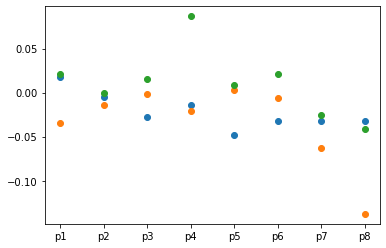

In [6]:
keys=['p1','p2','p3','p4','p5','p6','p7','p8']

plt.scatter(keys,[np.average(output['U (m s^-1)'].loc[i]) for i in keys])
plt.scatter(keys,[np.average(output['V (m s^-1)'].loc[i]) for i in keys])
plt.scatter(keys,[np.average(output['W (m s^-1)'].loc[i]) for i in keys])

plt.show()



In [39]:
type(output)

pandas.core.frame.DataFrame

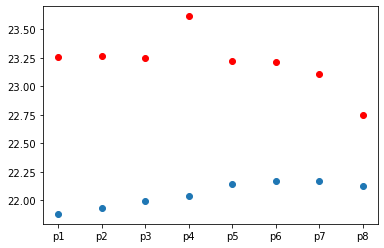

In [40]:
keys=['p1','p2','p3','p4','p5','p6','p7','p8']

plt.scatter(keys,[np.average(output['TSonic (K)'].loc[i])-273 for i in keys], color='red')
plt.scatter(keys,[np.average(output['T_HMP60 (C)'].loc[i]) for i in keys])

plt.show()

In [22]:
ysd=df_CR6.index[(df_CR6['TIMESTAMP'] == df_CR6['TIMESTAMP'].iloc[-1])].tolist()[0]
print(ysd)
print(df_CR6.index[(df_CR6['TIMESTAMP'] == df_CR6['TIMESTAMP'].iloc[8000])])

966846
Int64Index([8000], dtype='int64')


In [24]:
newdf = df_CR6.iloc[df_CR6.index[(df_CR6['TIMESTAMP'] == df_CR6['TIMESTAMP'].iloc[8000])].tolist():df_CR6.index[(df_CR6['TIMESTAMP'] == df_CR6['TIMESTAMP'].iloc[8010])].tolist()[0]]
#newdf = df_CR6.iloc[8000:8010]
print(newdf)

TypeError: cannot do slice indexing on <class 'pandas.core.indexes.numeric.Int64Index'> with these indexers [[8000]] of <class 'list'>

In [ ]:
tempdf = pd.DataFrame.from_dict({(i,j): dict[i][j] 
                            for i in dict.keys() 
                            for j in dict[i].keys()},
                            orient='index')

tempdf.index = pd.MultiIndex.from_tuples(tempdf.index)

In [ ]:
type(tempdf)

In [ ]:
output.to_csv(index=False)

In [ ]:
arrays = [[1, 1, 2, 2], ['red', 'blue', 'red', 'blue']]
pd.MultiIndex.from_arrays(arrays, names=('number', 'color'))

In [50]:
df_CR6_trim= df_CR6.iloc[df_CR6.index[(df_CR6['TIMESTAMP'] == df_pos['TIMESTAMP'].iloc[0].round('100ms'))].tolist()[0]:
                         df_CR6.index[(df_CR6['TIMESTAMP'] == df_pos['TIMESTAMP'].iloc[-1].round('100ms'))].tolist()[0]]


In [49]:
(df_CR6['TIMESTAMP'] == df_pos['TIMESTAMP'].iloc[0].round('100ms'))

0         False
1         False
2         False
3         False
4         False
          ...  
966842    False
966843    False
966844    False
966845    False
966846    False
Name: TIMESTAMP, Length: 966847, dtype: bool

In [8]:
len(output.loc['p1'])

1521